# 📊 Machine Learning Modeling: Crime & Socioeconomic Factors

This notebook continues the project by applying **machine learning models** to classify U.S. cities as high or low crime regions based on **education and unemployment levels**.
We will work with two targets:
- `violent_crime_class`: Binary class based on violent crime counts.
- `property_crime_class`: Binary class based on property crime counts.

We'll use:
- Logistic Regression
- Random Forest
- K-Nearest Neighbors

Each model will be evaluated using classification metrics and confusion matrices.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("preprocessed_data_for_ml.csv")
df.head()

,State_x,City,Population,Violent_Crime,Murder,Rape,Robbery,Aggravated_Assault,Property_Crime,Burglary,Larceny_Theft,Motor_Vehicle_Theft,Arson,State_Abbrev,State_y,Percent_Bachelors_or_Higher,Unemployment_Rate,violent_crime_class,property_crime_class
0,ALABAMA,Abbeville,2371.0,6.0,0.0,0.0,0.0,6.0,27.0,6.0,21.0,0.0,0.0,AL,AL,19.645014,2.902941,0,0
1,ALABAMA,Adamsville,4158.0,17.0,0.0,1.0,5.0,11.0,201.0,23.0,158.0,20.0,0.0,AL,AL,19.645014,2.902941,1,1
2,ALABAMA,Addison,674.0,3.0,0.0,1.0,0.0,2.0,14.0,2.0,10.0,2.0,0.0,AL,AL,19.645014,2.902941,0,0
3,ALABAMA,Alabaster,34120.0,37.0,1.0,1.0,5.0,30.0,551.0,16.0,518.0,17.0,2.0,AL,AL,19.645014,2.902941,1,1
4,ALABAMA,Albertville,22887.0,68.0,0.0,11.0,3.0,54.0,415.0,40.0,315.0,60.0,6.0,AL,AL,19.645014,2.902941,1,1


## 🎯 Define Features and Targets

In [2]:
features = ["Percent_Bachelors_or_Higher", "Unemployment_Rate"]
X = df[features]
y_violent = df["violent_crime_class"]
y_property = df["property_crime_class"]

## 🛠 Model Training and Evaluation Function

In [3]:
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(random_state=42),
        "KNN": KNeighborsClassifier()
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        report = classification_report(y_test, y_pred, output_dict=True)
        results[name] = {
            "model": model,
            "report": report,
            "conf_matrix": confusion_matrix(y_test, y_pred),
            "y_test": y_test,
            "y_pred": y_pred
        }
    return results

## 🔍 Train Models for Violent and Property Crime

In [4]:
violent_results = train_and_evaluate(X, y_violent)
property_results = train_and_evaluate(X, y_property)

## 📋 Summary Table of Model Performance

In [5]:
summary_rows = []
for target, res in zip(["Violent Crime", "Property Crime"], [violent_results, property_results]):
    for model_name, details in res.items():
        metrics = details["report"]["weighted avg"]
        summary_rows.append({
            "Target": target,
            "Model": model_name,
            "Precision": round(metrics["precision"], 3),
            "Recall": round(metrics["recall"], 3),
            "F1-score": round(metrics["f1-score"], 3),
            "Accuracy": round(details["report"]["accuracy"], 3),
        })
summary_df = pd.DataFrame(summary_rows)
summary_df

,Target,Model,Precision,Recall,F1-score,Accuracy
0,Violent Crime,Logistic Regression,0.539,0.539,0.516,0.539
1,Violent Crime,Random Forest,0.602,0.601,0.598,0.601
2,Violent Crime,KNN,0.600,0.601,0.599,0.601
3,Property Crime,Logistic Regression,0.562,0.561,0.555,0.561
4,Property Crime,Random Forest,0.597,0.598,0.597,0.598
5,Property Crime,KNN,0.603,0.603,0.601,0.603


## 📉 Confusion Matrices

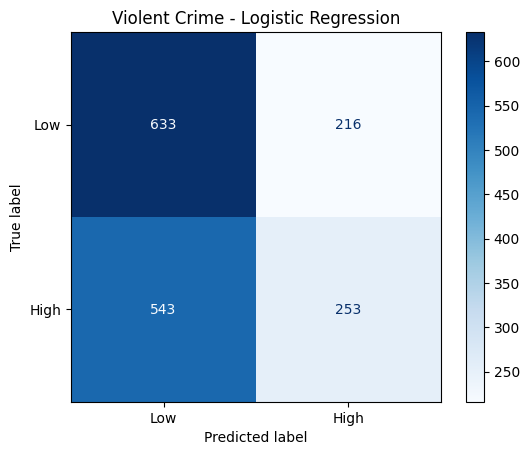

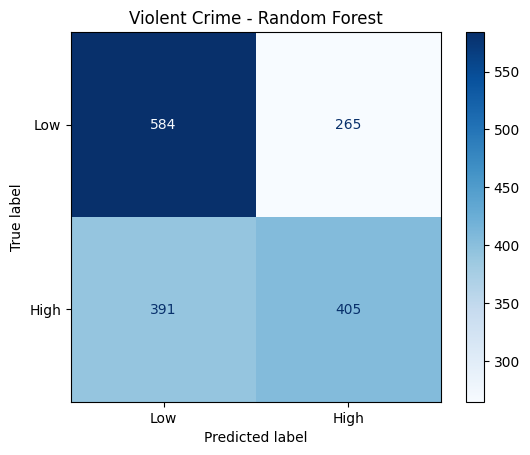

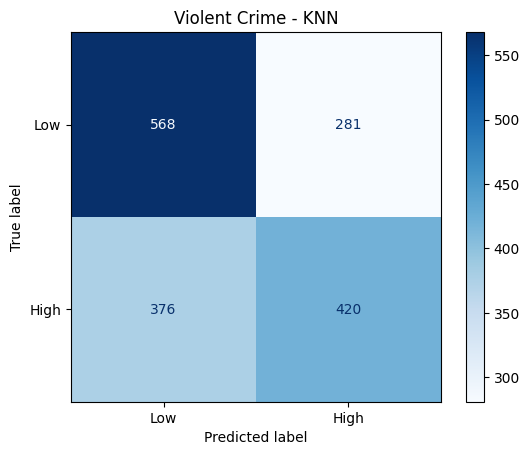

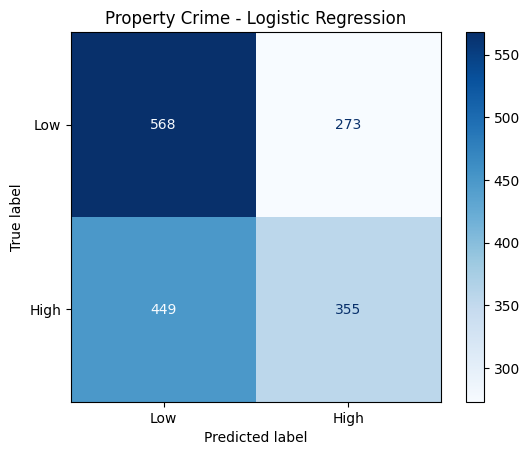

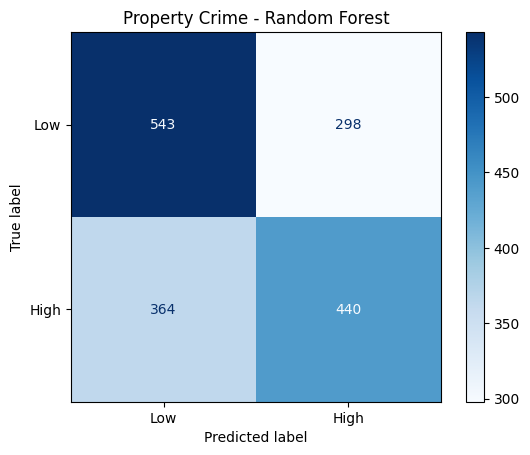

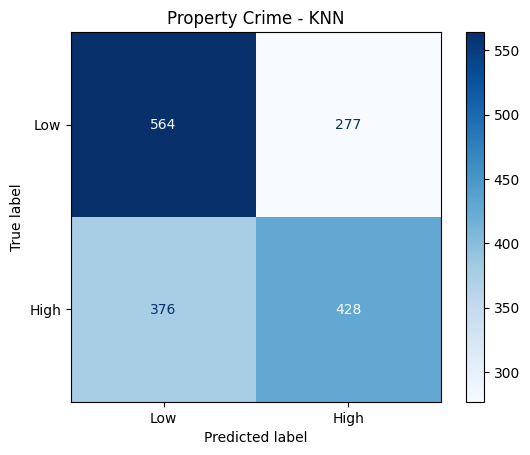

In [6]:
def plot_conf_matrices(results, title_prefix):
    for model_name, res in results.items():
        cm = res["conf_matrix"]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "High"])
        disp.plot(cmap='Blues')
        plt.title(f"{title_prefix} - {model_name}")
        plt.show()

plot_conf_matrices(violent_results, "Violent Crime")
plot_conf_matrices(property_results, "Property Crime")

## 🔬 Feature Importances

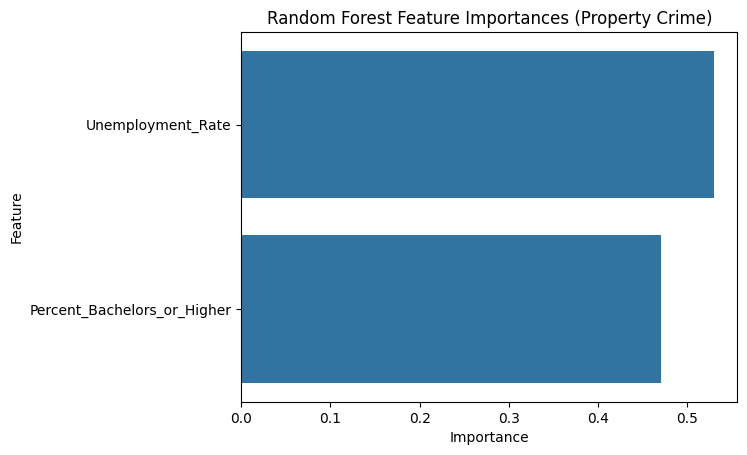

,Feature,Importance
1,Unemployment_Rate,0.529594
0,Percent_Bachelors_or_Higher,0.470406


In [7]:
importances = property_results["Random Forest"]["model"].feature_importances_
feat_imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

sns.barplot(x="Importance", y="Feature", data=feat_imp_df)
plt.title("Random Forest Feature Importances (Property Crime)")
plt.show()

feat_imp_df

## ROC Curves

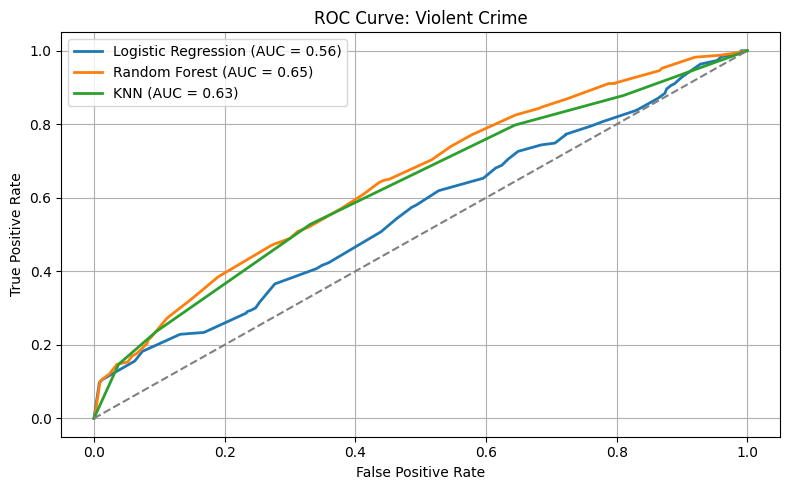

In [8]:
from sklearn.metrics import roc_curve, auc

def plot_roc(models_dict, X_test_scaled, y_test, title):
    plt.figure(figsize=(8, 5))
    for name, entry in models_dict.items():
        model = entry["model"]
        y_score = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {title}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y_violent, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

plot_roc(violent_results, X_test_scaled, y_test, "Violent Crime")


## Prediction Distribution

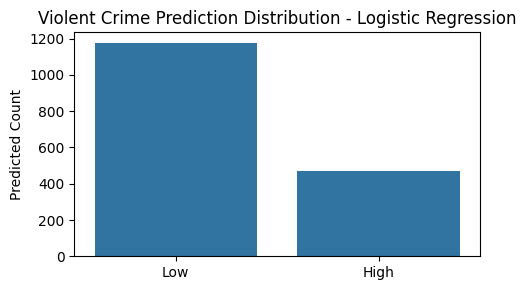

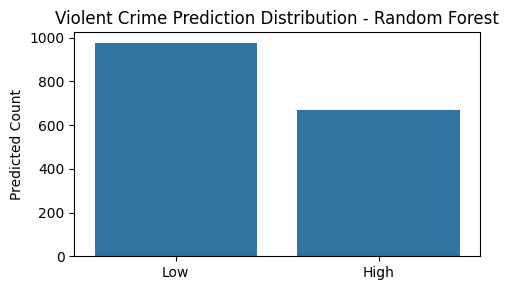

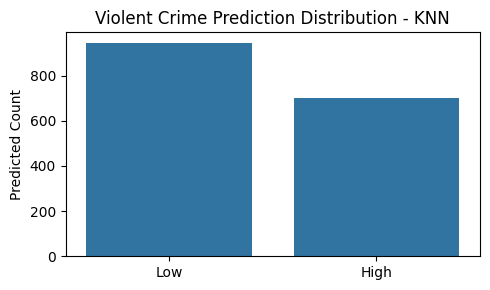

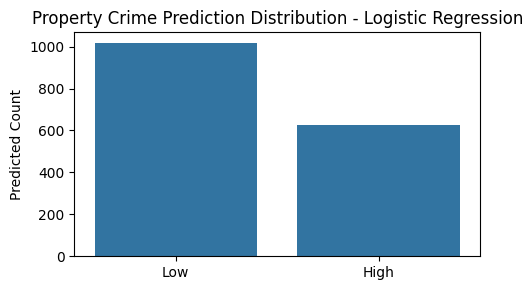

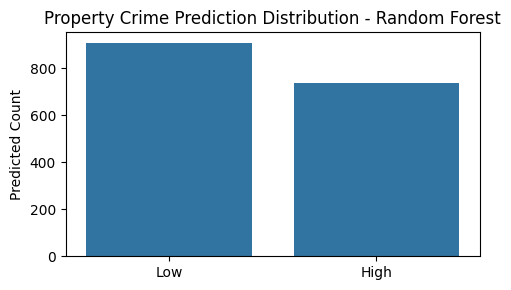

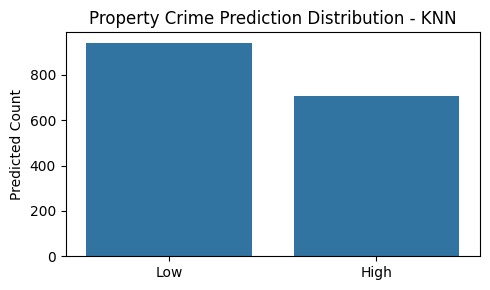

In [9]:
def plot_prediction_distribution(results_dict, title_prefix):
    for name, entry in results_dict.items():
        preds = entry["y_pred"]
        true_vals = entry["y_test"]
        plt.figure(figsize=(5, 3))
        sns.countplot(x=preds)
        plt.title(f"{title_prefix} Prediction Distribution - {name}")
        plt.xticks([0, 1], ['Low', 'High'])
        plt.ylabel("Predicted Count")
        plt.tight_layout()
        plt.show()

plot_prediction_distribution(violent_results, "Violent Crime")
plot_prediction_distribution(property_results, "Property Crime")


## Logistic Regression Coefficients Plot

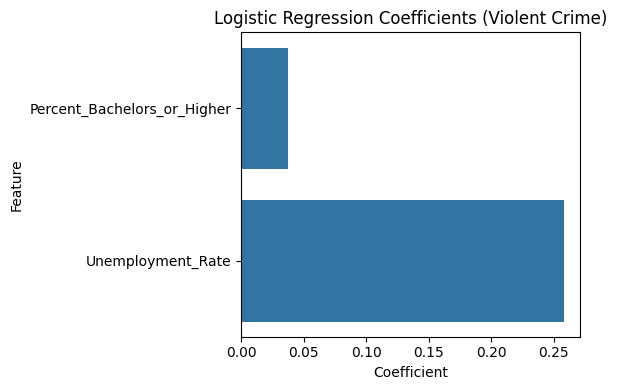

In [10]:
def plot_logistic_coefficients(model, feature_names, title):
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_[0]
    }).sort_values('Coefficient')

    plt.figure(figsize=(6, 4))
    sns.barplot(data=coef_df, x="Coefficient", y="Feature")
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(title)
    plt.tight_layout()
    plt.show()

logreg_model = violent_results["Logistic Regression"]["model"]
plot_logistic_coefficients(logreg_model, features, "Logistic Regression Coefficients (Violent Crime)")
